# 2: Self-consistent stellar systems 

In [1]:
# Essential - general
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Essential - astro
import astropy.units as u
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from astropy.constants import G

# Style
import matplotlib as mpl
import matplotlib.cm as cm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rcParams.update({'font.size': 25})

# 2.1: Sampling a system following a Plummer profile

In this notebook, we will generate initial conditions (positions and velocities) for a stellar system of $10^4$ stars. To do so, we will assume that the density of the system is that of a Plummer profile with mass $M = 10^6 {\rm M}_\odot$ and scale $b = 1$ kpc. Several methods exist to draw positions $(x,y,z)$ such that $r = \sqrt{x^2+y^2+z^2}$ is distributed according to $\rho(r)$. Below we will follow the method described in the Appendix of [Aarseth, Henon, Wielen (1974)](https://ui.adsabs.harvard.edu/abs/1974A%26A....37..183A/abstract).

In most cases, the difficulty with generating mock galaxies is not in the sampling of the spatial coordinates $\vec{x} = (x,y,z)$ but rather in sampling velocities $\vec{v} = (v_x,v_y,v_z)$ that are consistent with the spatial distribution. To ensure consistency we will need a distribution function $f(\vec{x}, \vec{v})$ such that $\rho(r) \propto \int f(\vec{x}, \vec{v})~{\rm d}^3v$ – such a system is called **self-consistent** because the distribution function $f$ generates the density, which in turn generates the gravitational potential.

For the Plummer, we can use a simple distribution function $f(\mathcal{E})$, known as a polytrope of order $n$, that is associated with this density profile for $(n=5)$ to generate the velocities (see Sect. 4.3.3 (a) of Binney & Tremaine, 2008)).


### Useful equations

---
The distribution function of a polytrope of order $n$   
$
\begin{equation}
f(\mathcal{E}) =  \begin{cases}
    F \mathcal{E}^{n-\frac{3}{2}} ~ &(\mathcal{E} \gt 0) \\
    0 ~ &(\mathcal{E}\leq 0)
    \end{cases}
\end{equation}
$  

where $\mathcal{E}$ and $\Psi$ are the relative energy and relative potential, defined as  
$
\begin{align}
    \Psi &\equiv \Phi_0 - \Phi \\ 
    \mathcal{E} &\equiv \Psi - \frac{1}{2}v^2
\end{align}
$

where $\Phi$ is the regular potential and $\Phi_0 = 0$ for an isolated system that extends to infinity. For such a system, $\Psi$ then is related to the density through Poisson's equation

$
\begin{equation}
\nabla^2\Psi = -4\pi G\rho
\end{equation}
$

---

The density distribution of a Plummer sphere is given by  
$
\begin{align}
\rho(r) &= \frac{3M}{4\pi b^3} \bigg(1+\frac{r^2}{b^2}\bigg)^{-\frac{5}{2}}, \\ 
     &= c_n \Psi^n \quad (\Psi\gt 0)
\end{align}
$

where $c_n = \frac{(2\pi)^{\frac{3}{2}}(n-\frac{3}{2})!F}{n!}$

---

Excercises:   
* Derive the expression for $\Psi(r)$ from the density.  
* Given that $\Phi(r) = -\frac{GM}{\sqrt{r^2+b^2}}$, derive the expression for $F$ 

We will now generate a self-consistent initial conditions for a Plummer model using the relevant section in [Aarseth, Henon, Wielen (1974)](https://ui.adsabs.harvard.edu/abs/1974A%26A....37..183A/abstract):



![](./imgs/BigApple-AHW-1974.png)

For a spherical system we can obtain $M(r)$ from the density

$
\begin{equation}
    M(r) = 4\pi \int_0^r x^2 \rho(x)~{\rm d}x
\end{equation}
$

For the Plummer, this results in  
$
\begin{equation}
     M(r) = \frac{M}{b^3} r^3 (1+\frac{r^2}{b^2})^{\frac{3}{2}},
\end{equation}
$  
where $M$ is the total mass of the system.

The code below generates a mock stellar system sampling from a Gaussian distribution. 

Excercise:  
* Modify the code below according to the steps described above. 

If you are running out of time: the solution is given a couple of cells below.

In [3]:
M = 1e6 * u.Msun
b = 1 * u.kpc

In [4]:
# Example generating a stellar system from a Gaussian distribution.
# Modify the code below using equations A2 and A3 in the text above to generate positions $(x,y,z)$ following a Plummer profile.

rng = np.random.default_rng(3)

N = 10_000
x, y, z = rng.normal(loc=0, scale=2, size=(3, N))

The general expression for the escape velocity is (if $\Phi(r) \rightarrow 0$ for $r \rightarrow \infty$)   
$
\begin{equation}
    v_e(r) \equiv \sqrt{2|\Phi(r)|}
\end{equation}
$

the potential of a Plummer profile is given by  
$
\begin{equation}
    \Phi(r) = - \frac{GM}{\sqrt{r^2 + b^2}}
\end{equation}
$

In [5]:
# Example generating velocities from a Gaussian distribution.
# Modify the equations below to the correct for a Plummer using equations A5 and A6

vx, vy, vz = rng.normal(loc=0, scale=1, size=(3, N))


### Now we will inspect whether the generated system is self-consistent with a Plummer model or not.
(probably not since it is a random Gaussian)

In [6]:
# First we generate a `gala.dynamics.PhaseSpacePosition`
pos = [x, y, z] * u.kpc
vel = [vx, vy, vz] * u.km/u.s

w0 = gd.PhaseSpacePosition(pos=pos,vel=vel)

In [7]:
# Next we integrate the distribution in a Plummer potential for 1 Gyr
potential = gp.PlummerPotential(m=M, b=b, units=galactic)
Hamiltonian = gp.Hamiltonian(potential)

orbits = Hamiltonian.integrate_orbit(w0, t = np.linspace(0,1,100)*u.Gyr, Integrator=gi.DOPRI853Integrator)

Text(0.5, 0, 'r [kpc]')

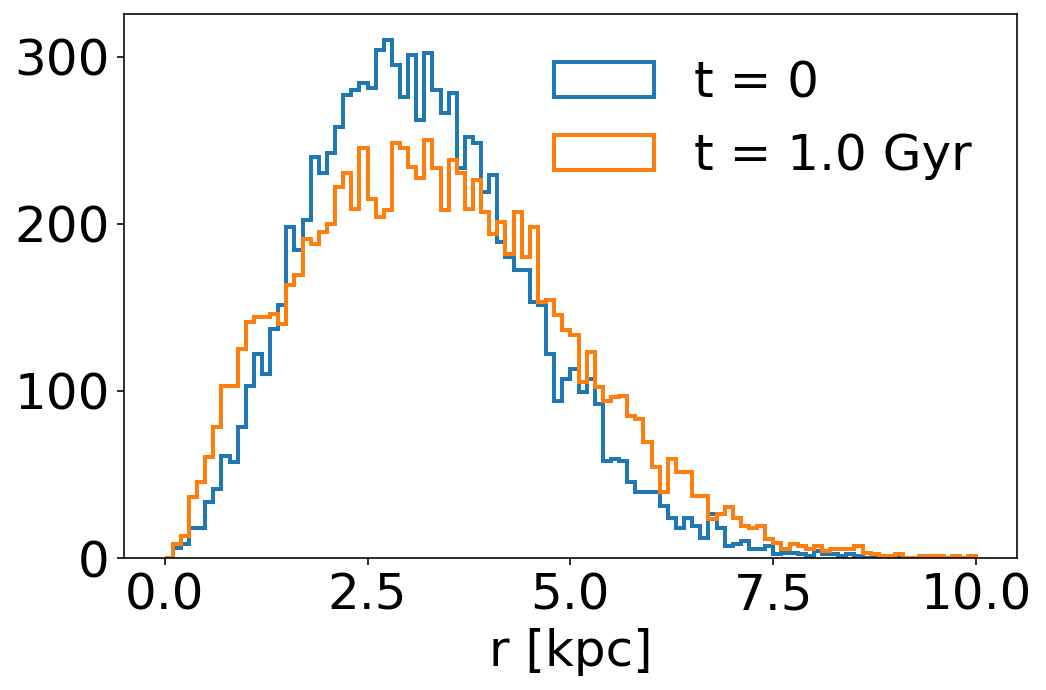

In [8]:
# Inspecting the evolution of the distribution: 
# if the system is self-consistent it's shape should not evolve.
r = orbits.spherical.distance 
r, r_unit = r.value, r.unit

plt.figure(figsize=(8,5))
args = dict(histtype='step', lw=2, bins=100, range=(0,10))
plt.hist(r[0], label='t = 0', **args);
plt.hist(r[-1], label='t = {}'.format(orbits.t[-1].to('Gyr')), **args);
plt.legend(frameon=False)

plt.xlabel(f'r [{r_unit}]')

### Generating a self-consistent system for a Plummer model  

<details>
  <summary>Click to expand!</summary>
  
```Python
def selfconsistent_plummer(N, M, b):
    """This function generates a stellar system that is consistent 
    with a Plummer, following (more or less) 
    the steps in Aarseth, Henon, Wielen (1974)

    Try to code this up yourself - if you have time."""
    x1 = rng.uniform(0, 1, size=N*2)

    r = b * (x1**(-2/3) -1)**-0.5
    r = r[r<5*u.kpc][0:N]

    xyz = rng.normal(size=(3,N))
    pos = xyz * r.value / np.linalg.norm(xyz, axis=0) * r.unit

    def v_esc(r):
        r = r if isinstance(r, u.Quantity) else r*u.kpc
        pot_abs = G*M / np.sqrt(r**2+b**2)
        return np.sqrt(2 * pot_abs).to('km/s')

    q = np.sqrt(rng.beta(1.5,4.5, size=N))
    v = q * v_esc(r)

    v_xyz = rng.normal(size=(3,N))
    vel = v_xyz * v.value / np.linalg.norm(v_xyz, axis=0)*v.unit

    return pos, vel
```
</details>

Text(0.5, 0, 'r [kpc]')

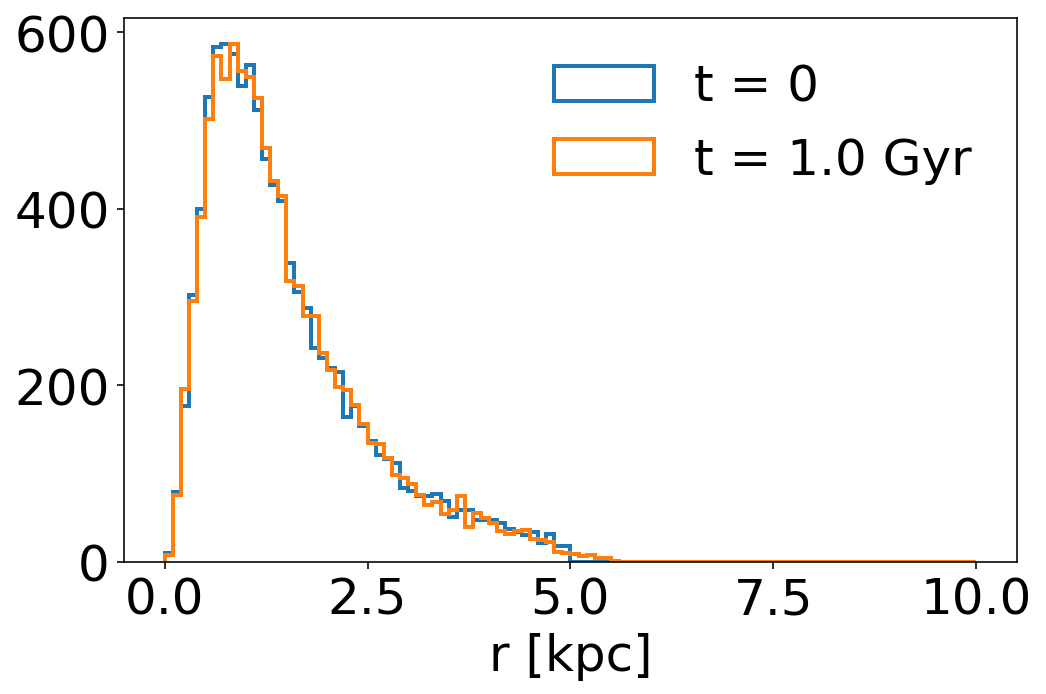

In [10]:
# Repeating the test of self-consistency
pos, vel = selfconsistent_plummer(N, M, b)
w0 = gd.PhaseSpacePosition(pos=pos,vel=vel)

orbits = Hamiltonian.integrate_orbit(w0, t = np.linspace(0,1,100)*u.Gyr, Integrator=gi.DOPRI853Integrator)

r = orbits.spherical.distance 
r, r_unit = r.value, r.unit

plt.figure(figsize=(8,5))
plt.hist(r[0], histtype='step', lw=2, bins=100, label='t = 0', range=(0,10));
plt.hist(r[-1], histtype='step', lw=2, bins=100, label='t = {}'.format(orbits.t[-1].to('Gyr')), range=(0,10));
plt.legend(frameon=False)

plt.xlabel(f'r [{r_unit}]')

> Exercise  

Inspect the system:
- Inspect (by plotting) the distribution of the energies 
- Compute the velocity dispersion in each of the directions $(x,y,z)$. What is the shape of the velocity ellipsoid? Why?
- Can you think of a better test of self-consistency? You could look at the evolution of the size of the system – or at the amplitude of its velocity distribution $\sigma_v$.

# 2.2:  A small galaxy embedded in a dark matter halo
For the final part we will generate a new stellar system: a spherical galaxy in a dark matter halo. For simplicity, assume that both components are described by a Plummer profile.   
For the stellar component use $M_\star = 10^4 {\rm M}_\odot$ and scale $b_\star= 0.05$ kpc and for the dark matter component use $M_{\rm DM} = 10^6 {\rm M}_\odot$ and scale $b_{\rm DM} = 1$ kpc.

Use the same method as before to generate the spatial distribution of the stellar component.

To obtain the velocities of the stars we will have to solve the Jeans equations.  
The Jeans equation in spherical coordinates are (Section 4.8.1 of Binney & Tremaine):  
$ \large \frac{d\big(\rho_\star(r)\sigma^2_v(r)\big)}{dr} + \rho_\star(r) \frac{d\Phi(r)}{dr}= 0$ 

Use the equation above to find the velocity dispersion of the system as a function of radius $\sigma_v(r)$.
Assume that the potential is dominated by the dark matter component. For the density in the equation above use the density of the stellar component.   
Finally, by assuming that the velocity distribution is well described by a Gaussian, generate velocities for the stellar particles using the velocity dispersion obtained from the Jeans equation.   


$
\begin{equation}
\sigma_v^2(r) = \frac{1}{\rho_\star(r)} \int_r^\infty \rho_\star(r') \frac{{\rm d}\Phi(r')}{{\rm d}r'} ~ dr'
\end{equation}
$

In [11]:
M_star, b_star = 1e3*u.Msun, 0.05*u.kpc
M_dm, b_dm = 1e6*u.Msun, 1*u.kpc

p_star = gp.PlummerPotential(m=M_star, b=b_star, units=galactic)
p_dm = gp.PlummerPotential(m=M_dm, b=b_dm, units=galactic)

In [12]:
# Solving the integral for sigma_v(r):
def integrand(x):
    b1, b2 = b_star.value, b_dm.value
    
    p1 = np.power(1+(x/b1)**2, -5/2)
    p2 = np.power(x**2+b2**2, -3/2)
    return p1 * p2 * x

def sigma_v(r):
    # strip r from unit
    r, unit = (r.value, r.unit) if isinstance(r, u.Quantity) else (r, u.kpc)
    
    int_, err = quad(integrand, r, np.infty)
    int_ = int_ / unit

    sv_2 = int_ * G*M_dm* (1+((r*unit)/b_star)**2)**(5/2)
    return np.sqrt(sv_2).to('km/s')
    

### Generating a self-consistent system for a 2-component Plummer model  

<details>
  <summary>Click to expand!</summary>
  
```Python
# Generating the IC
def generate_2comp_Plummer(N_star):
    xyz, _ = selfconsistent_plummer(N_star, M_star, b_star)
    r = np.linalg.norm(xyz, axis=0)

    s_v = np.array([sigma_v(ri).value for ri in r]) 
    v = rng.normal(scale=s_v, size=N_star) 

    v_xyz = rng.normal(size=(3, N_star))
    v_xyz = v * v_xyz / np.linalg.norm(v_xyz, axis=0) * u.km/u.s
    return xyz, v_xyz
```
</details>

In [14]:
xyz, v_xyz = generate_2comp_Plummer(N_star=10_000)

Text(0.5, 0, 'r [kpc]')

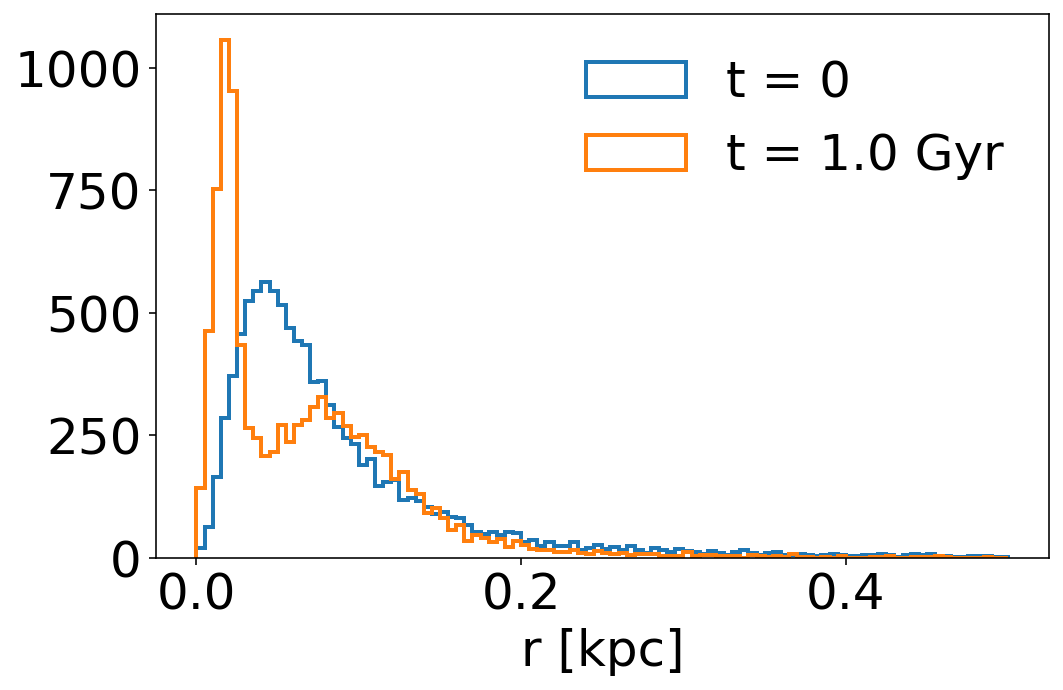

In [15]:
# Repeating the test of self-consistency
w0 = gd.PhaseSpacePosition(pos=xyz, vel=v_xyz)

potential = gp.CompositePotential(star = p_star, dm = p_dm)
Hamiltonian = gp.Hamiltonian(potential)

orbits = Hamiltonian.integrate_orbit(w0, t = np.linspace(0,1,100)*u.Gyr, Integrator=gi.DOPRI853Integrator)

r = orbits.spherical.distance 
r, r_unit = r.value, r.unit

plt.figure(figsize=(8,5))
plt.hist(r[0], histtype='step', lw=2, bins=100, label='t = 0', range=(0,0.5));
plt.hist(r[-1], histtype='step', lw=2, bins=100, label='t = {}'.format(orbits.t[-1].to('Gyr')), range=(0,0.5));
plt.legend(frameon=False)

plt.xlabel(f'r [{r_unit}]')

> Exercise

As you can see, the system is not fully self-consistent. There appear to be two regimes with a transition at $\sim 0.05$ kpc. Can you figure out why? Can you confirm your suspicion?

**Bonus**: generate initial conditions for both the stellar and dark matter component, this will be interesting for the next notebook!

